In [1]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
import xgboost as xgb
import seaborn as sns
from scipy.stats import skew
import numpy as np
import datetime

In [2]:
elect = pd.read_csv('final_dataset.csv')
elect = elect.set_index('time')
elect.index = pd.to_datetime(elect.index)


day = range(6, 14)
afternoon = range(14, 24)
night = range(0, 6)

def season(x):
    if x in day:
       return 1
    if x in afternoon:
       return 2
    else :
       return 3

elect['type'] = elect.index.to_series().dt.hour.map(lambda x : season(x))

In [3]:
elect = elect.reset_index()
elect = elect.drop(columns=['time'])
elect = elect.dropna()

In [4]:
numeric_feats = elect.dtypes[elect.dtypes != "object"].index

skewed_feats = elect[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
elect[skewed_feats] = np.log1p(elect[skewed_feats])

In [5]:
elect.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Precipitation,CloudCover,Temperature,Snowfall,Wind,type
0,5.721760,2.490392,28947.47,7.138391,0.0,3.583519,0.000000,1.329846e-07,0.999695,286.43298,0.0,9.663516,3
1,5.731527,2.549914,29187.95,7.136801,0.0,3.610918,0.000000,2.353721e-07,0.556274,285.98602,0.0,8.988889,3
2,5.697489,2.516890,29088.29,7.103815,0.0,3.583519,0.000000,3.708733e-09,0.164459,284.50214,0.0,6.604268,3
3,5.687585,2.532108,28892.16,7.102005,0.0,3.526361,0.000000,0.000000e+00,0.197144,283.30905,0.0,7.486063,1
4,5.817920,2.276446,28855.32,7.234898,0.0,1.386294,6.583409,2.053049e-08,0.172791,282.31317,0.0,8.071110,1


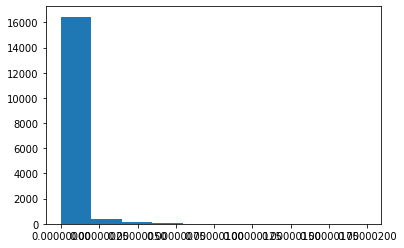

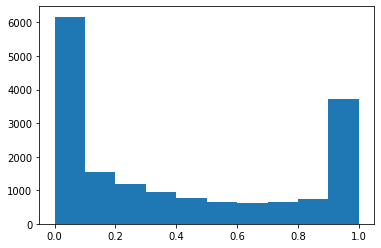

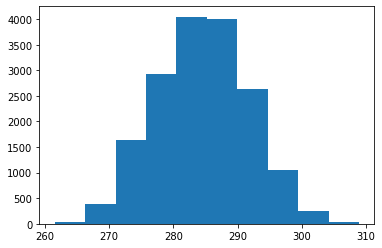

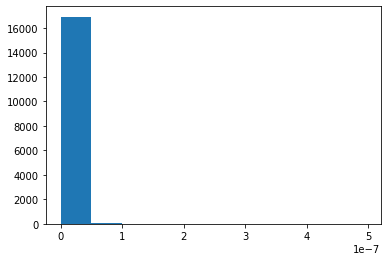

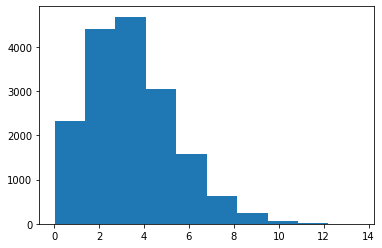

In [6]:
for column in ['Precipitation', 'CloudCover', 'Temperature', 'Snowfall', 'Wind']:
    plt.hist(elect[column])
    plt.show()

In [7]:
scaler = StandardScaler()
elect[['Precipitation',
       'CloudCover',
       'Temperature',
       'Snowfall',
       'Wind']] = scaler.fit_transform(elect[['Precipitation',
                                              'CloudCover',
                                              'Temperature',
                                              'Snowfall',
                                              'Wind']])

In [8]:
elect.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Precipitation,CloudCover,Temperature,Snowfall,Wind,type
0,5.721760,2.490392,28947.47,7.138391,0.0,3.583519,0.000000,1.397354,1.524958,0.261999,-0.064596,3.262164,3
1,5.731527,2.549914,29187.95,7.136801,0.0,3.610918,0.000000,2.688839,0.390834,0.199461,-0.064596,2.908499,3
2,5.697489,2.516890,29088.29,7.103815,0.0,3.583519,0.000000,-0.233293,-0.611301,-0.008164,-0.064596,1.658390,3
3,5.687585,2.532108,28892.16,7.102005,0.0,3.526361,0.000000,-0.280073,-0.527705,-0.175101,-0.064596,2.120661,1
4,5.817920,2.276446,28855.32,7.234898,0.0,1.386294,6.583409,-0.021108,-0.589992,-0.314444,-0.064596,2.427365,1


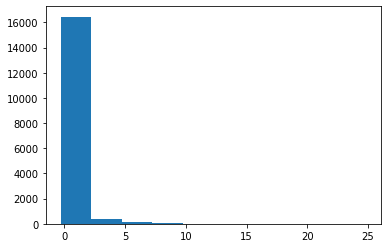

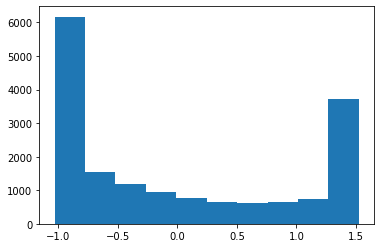

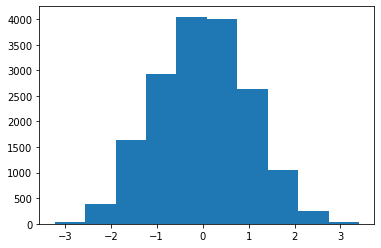

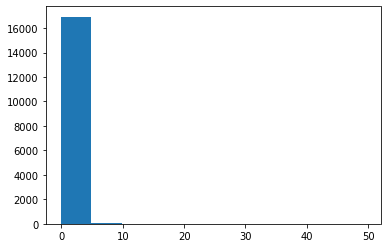

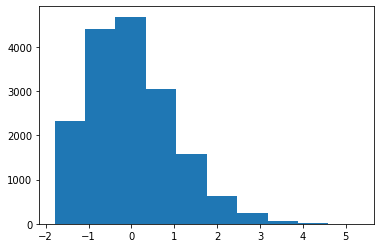

In [9]:
for column in ['Precipitation', 'CloudCover', 'Temperature', 'Snowfall', 'Wind']:
    plt.hist(elect[column])
    plt.show()

Text(0.5, 1, 'Correlation between different fearures')

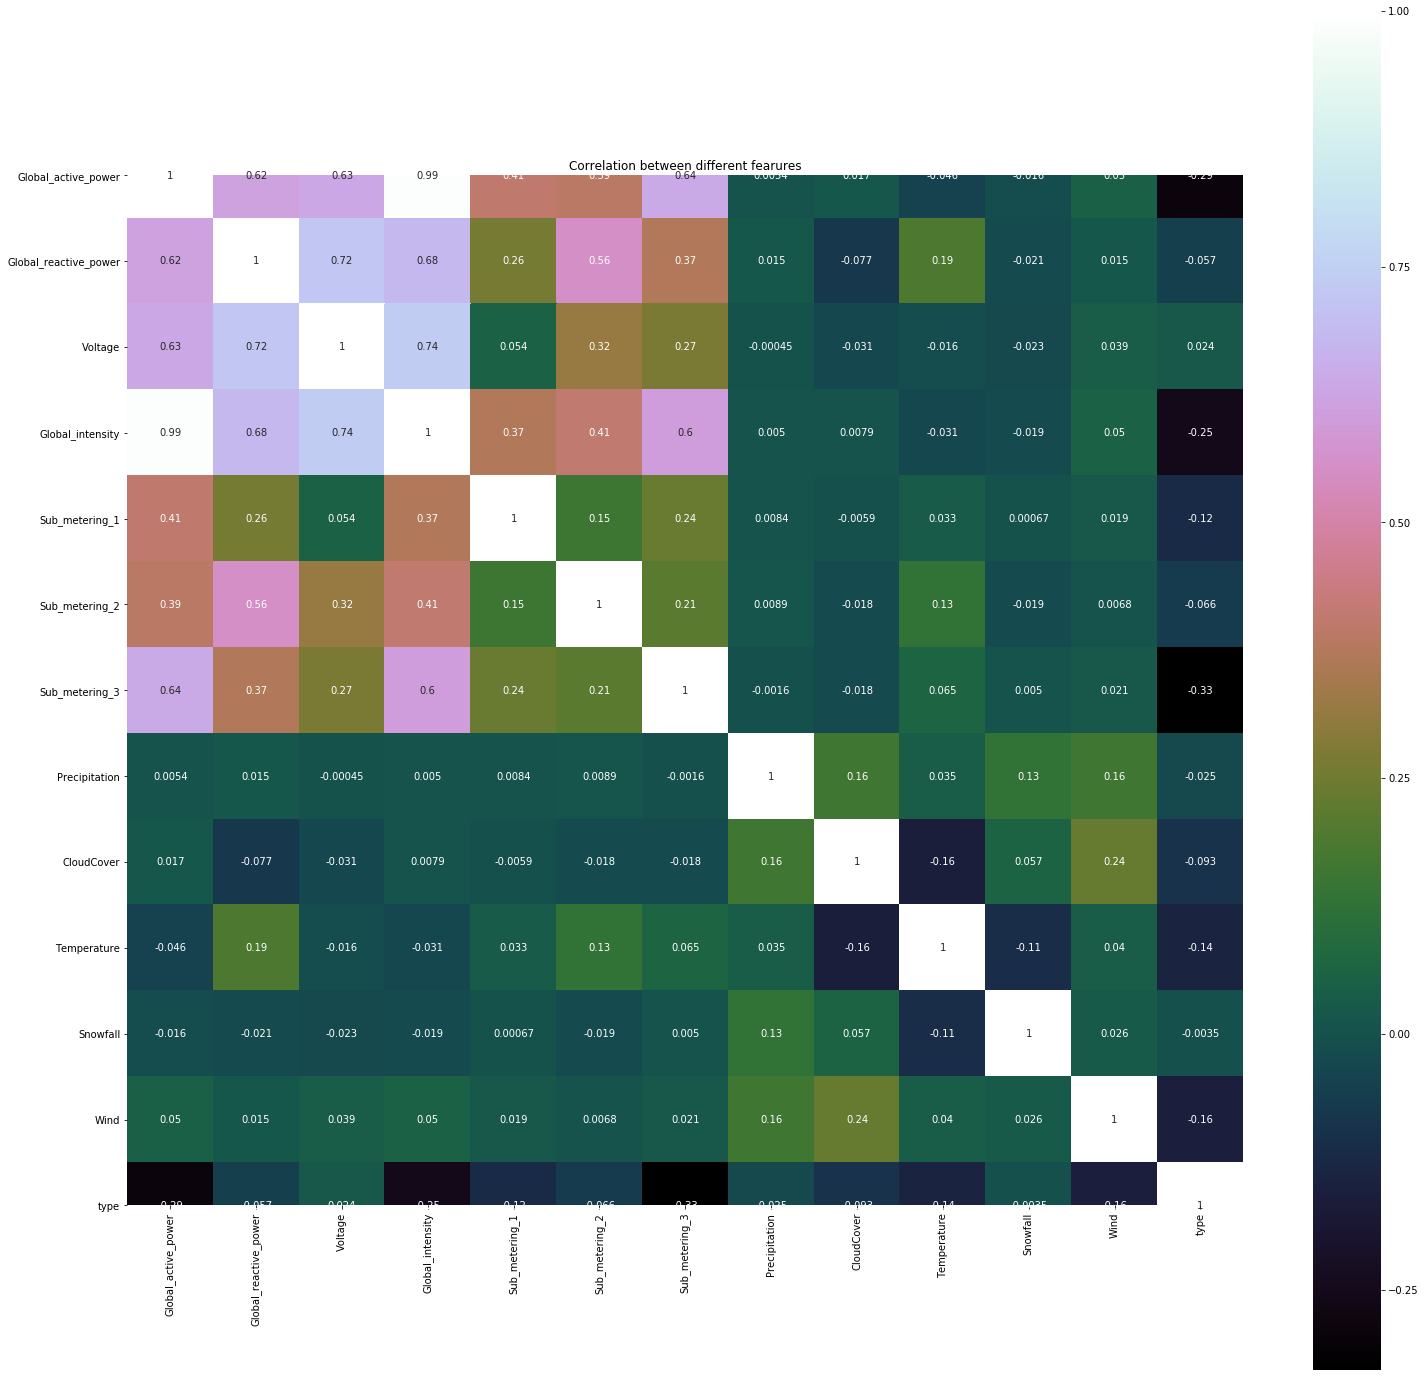

In [10]:
correlation = elect.corr()
plt.figure(figsize=(25,25))
sns.heatmap(correlation, vmax=1, square=True, annot=True,cmap='cubehelix')
plt.title('Correlation between different fearures')

In [11]:
feature_list = list(elect.columns)
def groupFeatures(features):
    features_bin = []
    features_cat = []
    features_etc = []
    for feature in features:
        if 'bin' in feature:
            features_bin.append(feature)
        elif 'cat' in feature:
            features_cat.append(feature)
        elif 'id' in feature or 'target' in feature:
            continue
        else:
            features_etc.append(feature)
    return features_bin, features_cat, features_etc

feature_list_bin, feature_list_cat, feature_list_etc = groupFeatures(feature_list)
print("# of binary feature : ", len(feature_list_bin))
print("# of categorical feature : ", len(feature_list_cat))
print("# of other feature : ", len(feature_list_etc))

# of binary feature :  0
# of categorical feature :  0
# of other feature :  13


In [12]:
X = elect.loc[:, elect.columns != 'Global_active_power']
y = elect.loc[:, elect.columns == 'Global_active_power']
X = X.drop(columns=[
                    'Global_reactive_power',
                    'Sub_metering_1',
                    'Sub_metering_2',
                    'Sub_metering_3',
                    'Voltage',
                    'Global_intensity'])
X

,Precipitation,CloudCover,Temperature,Snowfall,Wind,type
0,1.397354,1.524958,0.261999,-0.064596,3.262164,3
1,2.688839,0.390834,0.199461,-0.064596,2.908499,3
2,-0.233293,-0.611301,-0.008164,-0.064596,1.658390,3
3,-0.280073,-0.527705,-0.175101,-0.064596,2.120661,1
4,-0.021108,-0.589992,-0.314444,-0.064596,2.427365,1
...,...,...,...,...,...,...
17290,-0.280073,1.525738,-0.829895,-0.064596,-0.915405,2
17291,-0.260024,1.525738,-0.821491,-0.064596,-1.316028,2
17292,-0.116340,1.525738,-0.890319,-0.064596,-1.436548,2
17293,-0.248329,1.520899,-0.935723,-0.064596,-1.332359,2


In [13]:
y

,Global_active_power
0,5.721760
1,5.731527
2,5.697489
3,5.687585
4,5.817920
...,...
17290,5.234856
17291,5.438366
17292,5.639671
17293,5.153835


In [14]:
yclass = pd.cut(y.Global_active_power,bins=[0,4.5,9],labels=[0, 1])

In [15]:
yclass = pd.DataFrame(yclass)

In [16]:
xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.25)

/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pereza/miniconda3/envs/universidad/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

The MSE error for the train is:  2.8537093213003106
The correlation for the train is:  -38.91970525640812
The MSE error for the test is:  2.904590940598661
The correlation for the test is:  -1.6036016309843406


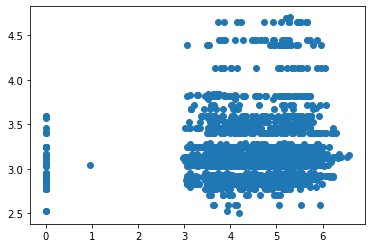

In [17]:
# Choose the type of classifier.
abreg = AdaBoostRegressor()
# Choose some parameter combinations to try
params = {
       'n_estimators': [50, 100],
       'learning_rate' : [0.01, 0.05, 0.1, 0.5],
       'loss' : ['linear', 'square', 'exponential']
}
score = make_scorer(mean_squared_error)

gridsearch=GridSearchCV(abreg, params, scoring=score, cv=5, return_train_score=True)
gridsearch.fit(xtrain, ytrain)

best_estim=gridsearch.best_estimator_

best_estim.fit(xtrain,ytrain)
ytr_pred=best_estim.predict(xtrain)
mse = mean_squared_error(ytr_pred,ytrain)
r2 = r2_score(ytr_pred,ytrain)

print('The MSE error for the train is: ', mse)
print('The correlation for the train is: ', r2)

ypred=best_estim.predict(xtest)
mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print('The MSE error for the test is: ', mse)
print('The correlation for the test is: ', r2)

plt.scatter(ytest, ypred)
plt.show()

In [ ]:
xgb_reg = xgb.XGBRegressor(objective = 'reg:linear')
xgb_params = {
  'learning_rate': [0.01, 0.05, 0.1],
  'n_estimators' : [15, 30, 50, 80, 100, 150, 200],
  'max_depth': [3,6],
  'min_child_weight':[7],
  'gamma': [0.01, 0.05, 0.1, 0.5, 1.5, 10],
  'subsample':[ .8, .9]
}
grid_search = GridSearchCV(xgb_reg,xgb_params,cv=5,verbose=90,n_jobs=1)

grid_search = grid_search.fit(xtrain, ytrain)

xgboost_reg = grid_search.best_estimator_

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.8 
[16:24:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.8, score=-10.370, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.8 
[16:24:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight

[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9, score=-8.599, total=   0.1s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.3s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:24:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9, score=-7.695, total=   0.1s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.4s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:24:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[C

[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8, score=-2.688, total=   0.3s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    4.4s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8 
[16:24:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8, score=-3.270, total=   0.3s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.6s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:24:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[C

[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8, score=-0.535, total=   0.5s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    9.7s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8 
[16:24:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8, score=-0.618, total=   0.5s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:   10.1s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8 
[16:24:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9, score=-0.080, total=   0.6s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   19.1s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9 
[16:24:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9, score=-0.095, total=   0.6s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   19.8s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9 
[16:24:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.8, score=-9.020, total=   0.2s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   22.0s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:24:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9, score=-7.629, total=   0.2s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   22.2s remaining:    0.0s
[CV] gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:24:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[C

[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.8, score=-2.694, total=   0.5s
[CV] gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.8 
[16:25:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.8, score=-3.277, total=   0.5s
[CV] gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:25:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9, score=-2.691, total=   0.4s
[CV] gamma=0.01, learning_rate=

[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.8, score=-0.537, total=   0.9s
[CV] gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.8 
[16:25:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.8, score=-0.724, total=   0.9s
[CV] gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9 
[16:25:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9, score=-0.540, total=   0.9s
[CV] gamma=0.01, learning_

[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.8, score=-2.894, total=   0.1s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.8 
[16:25:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.8, score=-3.509, total=   0.1s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.9 
[16:25:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.9, score=-2.890, total=   0.1s
[CV] gamma=0.01, learning_rate=

[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.8, score=0.069, total=   0.2s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.8 
[16:25:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.8, score=0.047, total=   0.2s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.9 
[16:25:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.076, total=   0.2s
[CV] gamma=0.01, learning_rate=0.0

[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.8, score=0.144, total=   0.3s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.8 
[16:25:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.8, score=0.174, total=   0.3s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.9 
[16:25:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.9, score=0.158, total=   0.3s
[CV] gamma=0.01, learning_rat

[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.8, score=0.138, total=   0.6s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.8 
[16:25:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.8, score=0.174, total=   0.6s
[CV] gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9 
[16:25:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9, score=0.153, total=   0.6s
[CV] gamma=0.01, learning_rat

[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.8, score=-0.678, total=   0.2s
[CV] gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:25:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9, score=-0.499, total=   0.2s
[CV] gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:25:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9, score=-0.563, total=   0.2s
[CV] gamma=0.01, learning_rate=

[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.8, score=0.159, total=   0.5s
[CV] gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:26:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.144, total=   0.5s
[CV] gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:26:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.184, total=   0.5s
[CV] gamma=0.01, learning_rate=0.0

[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.8, score=0.170, total=   0.9s
[CV] gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9 
[16:26:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.142, total=   0.8s
[CV] gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9 
[16:26:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.190, total=   0.8s
[CV] gamma=0.01, learning_rat

[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.9, score=-0.423, total=   0.1s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.9 
[16:26:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.9, score=-0.438, total=   0.1s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.9 
[16:26:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=15, subsample=0.9, score=-0.603, total=   0.1s
[CV] gamma=0.01, learning_rate=0.1, 

[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.159, total=   0.2s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.9 
[16:26:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.142, total=   0.2s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.9 
[16:26:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.174, total=   0.2s
[CV] gamma=0.01, learning_rate=0.1, max

[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.9, score=0.163, total=   0.3s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.9 
[16:26:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.9, score=0.140, total=   0.3s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.9 
[16:26:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.9, score=0.175, total=   0.3s
[CV] gamma=0.01, learning_rate=0.1

[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9, score=0.155, total=   0.6s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9 
[16:26:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9, score=0.127, total=   0.6s
[CV] gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9 
[16:26:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200, subsample=0.9, score=0.169, total=   0.6s
[CV] gamma=0.01, learning_rate=0.1

[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9, score=0.110, total=   0.2s
[CV] gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:26:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.9, score=0.122, total=   0.2s
[CV] gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.8 
[16:26:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.8, score=0.143, total=   0.3s
[CV] gamma=0.01, learning_rate=0.1, max

[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.117, total=   0.4s
[CV] gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:26:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.167, total=   0.5s
[CV] gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.8 
[16:26:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.8, score=0.137, total=   0.6s
[CV] gamma=0.01, learning_rate=0.1, m

[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.105, total=   0.8s
[CV] gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9 
[16:27:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.153, total=   0.8s
[CV] gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.8 
[16:27:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.01, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.8, score=0.121, total=   1.1s
[CV] gamma=0.01, learning_rate=0.1

[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8, score=-7.627, total=   0.1s
[CV] gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8 
[16:27:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8, score=-8.598, total=   0.1s
[CV] gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8 
[16:27:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8, score=-7.694, total=   0.1s
[CV] gamma=0.05, learning_rate=

[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8, score=-2.687, total=   0.3s
[CV] gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8 
[16:27:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8, score=-3.048, total=   0.3s
[CV] gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8 
[16:27:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8, score=-2.686, total=   0.3s
[CV] gamma=0.05, learning_rate=

[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8, score=-0.535, total=   0.5s
[CV] gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8 
[16:27:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8, score=-0.617, total=   0.5s
[CV] gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8 
[16:27:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8, score=-0.518, total=   0.5s
[CV] gamma=0.05, learning_

[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.8, score=-10.479, total=   0.1s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.8 
[16:27:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.8, score=-10.447, total=   0.1s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.8 
[16:27:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.8, score=-12.190, total=   0.1s
[CV] gamma=0.05, learning_ra

[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.8, score=-5.070, total=   0.3s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.8 
[16:27:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.8, score=-5.073, total=   0.3s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.8 
[16:27:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.8, score=-6.030, total=   0.3s
[CV] gamma=0.05, learning_rate=

[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.8, score=-1.724, total=   0.6s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.8 
[16:27:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.8, score=-1.745, total=   0.6s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.8 
[16:27:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.8, score=-2.167, total=   0.6s
[CV] gamma=0.05, learning_

[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.8, score=-0.071, total=   1.2s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.8 
[16:28:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.8, score=-0.100, total=   1.2s
[CV] gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.8 
[16:28:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.8, score=-0.178, total=   1.2s
[CV] gamma=0.05, learning_

[16:28:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8, score=-0.490, total=   0.1s
[CV] gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8 
[16:28:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.8, score=-0.666, total=   0.1s
[CV] gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:28:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fav

[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8, score=0.142, total=   0.3s
[CV] gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8 
[16:28:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.8, score=0.166, total=   0.3s
[CV] gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:28:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.155, total=   0.2s
[CV] gamma=0.05, learning_rate=0.0

[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8, score=0.141, total=   0.5s
[CV] gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8 
[16:28:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.8, score=0.176, total=   0.5s
[CV] gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.9 
[16:28:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.155, total=   0.4s
[CV] gamma=0.05, learning_rat

[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9, score=-2.892, total=   0.1s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9 
[16:28:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9, score=-3.274, total=   0.1s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9 
[16:28:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9, score=-2.883, total=   0.1s
[CV] gamma=0.05, learning_rate=

[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.068, total=   0.3s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9 
[16:28:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.090, total=   0.3s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9 
[16:28:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.091, total=   0.3s
[CV] gamma=0.05, learning_rate=0.0

[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.9, score=0.145, total=   0.6s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.9 
[16:28:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.9, score=0.190, total=   0.6s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.9 
[16:28:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100, subsample=0.9, score=0.157, total=   0.6s
[CV] gamma=0.05, learning_rat

[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.9, score=0.141, total=   1.1s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.9 
[16:29:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.9, score=0.189, total=   1.1s
[CV] gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.9 
[16:29:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, subsample=0.9, score=0.150, total=   1.1s
[CV] gamma=0.05, learning_rat

[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9, score=0.142, total=   0.1s
[CV] gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:29:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9, score=0.125, total=   0.1s
[CV] gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9 
[16:29:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=30, subsample=0.9, score=0.129, total=   0.1s
[CV] gamma=0.05, learning_rate=0.1, max

[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.162, total=   0.2s
[CV] gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:29:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.140, total=   0.2s
[CV] gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9 
[16:29:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=80, subsample=0.9, score=0.175, total=   0.2s
[CV] gamma=0.05, learning_rate=0.1, max

[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.162, total=   0.4s
[CV] gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.9 
[16:29:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.132, total=   0.4s
[CV] gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.9 
[16:29:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=150, subsample=0.9, score=0.172, total=   0.4s
[CV] gamma=0.05, learning_rate=0.1

[CV]  gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9, score=-0.446, total=   0.1s
[CV] gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9 
[16:29:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=15, subsample=0.9, score=-0.613, total=   0.1s
[CV] gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.8 
[16:29:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=30, subsample=0.8, score=0.123, total=   0.2s
[CV] gamma=0.05, learning_rate=0.1, m

[CV]  gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.126, total=   0.3s
[CV] gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9 
[16:29:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=50, subsample=0.9, score=0.165, total=   0.3s
[CV] gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.8 
[16:29:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=80, subsample=0.8, score=0.137, total=   0.5s
[CV] gamma=0.05, learning_rate=0.1, max

In [ ]:
preds_xgb_reg_test = xgboost_reg.predict(xtest)
  
plt.scatter(ytest, preds_xgb_reg_test)
plt.show()
  
mse = mean_squared_error(ytest, preds_xgb_reg_test)
r2 = r2_score(ytest, preds_xgb_reg_test)
print('The MSE error for the test is: ', mse)
print('The correlation for the test is: ', r2)

# Clasificación:

In [ ]:
plt.hist(y['Global_active_power'])

In [ ]:
yclass = pd.cut(y.Global_active_power,bins=[0,4,8],labels=[0, 1])
yclass = pd.DataFrame(yclass)

In [ ]:
yclass

In [ ]:
X

In [ ]:
new_df = pd.merge(X, yclass, left_index=True, right_index=True, how = "outer")
new_df = new_df.dropna()

In [ ]:
X = new_df.loc[:, new_df.columns != 'Global_active_power']
y = new_df.loc[:, new_df.columns == 'Global_active_power']

In [ ]:
plt.hist(y['Global_active_power'])

In [ ]:
xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.25)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" : ["best", "random"],
              "n_estimators": [1, 2, 5, 10, 20, 40, 60, 85, 100, 150, 300, 400, 600, 750],
              "learning_rate": [0.01, 0.05, 0.1, 0.3, 0.4, 0.8, 1, 1.5]
             }
# Choose the type of classifier.
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", max_depth = None)
ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc', cv = 5)
grid_search_ABC = grid_search_ABC.fit(xtrain, ytrain)

In [ ]:
# Set the clf to the best combination of parameters
Ada_tuned = grid_search_ABC.best_estimator_
# Fit the best algorithm to the data.
Ada_tuned = Ada_tuned.fit(xtrain, ytrain)
pred_test_adatuned = Ada_tuned.predict_proba(xtest)[:,1]

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(ytest, pred_test_adatuned)
roc_auc = auc(fpr, tpr)
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

In [ ]:
xgboost_model = xgb.XGBClassifier()
parameters = {'nthread':[2, 4, 8], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [1, 5, 11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.3, 0.7, 1],
              'n_estimators': [5, 15, 25, 50, 75, 100, 200, 300, 500],
              'missing':[-999],
              'seed': [1337]}

# Type of scoring used to compare parameter combinations
# Run the grid search
grid_obj = GridSearchCV(xgboost_model, parameters, n_jobs=5,
                        cv=5, scoring='roc_auc', verbose=2, refit=True)

grid_obj = grid_obj.fit(xtrain, ytrain)
# Set the clf to the best combination of parameters
xgboost_model = grid_obj.best_estimator_
# Fit the best algorithm to the data.
xgboost_model = xgboost_model.fit(xtrain, ytrain)
xgboost_pred_test = xgboost_model.predict_proba(xtest)[:,1]

In [ ]:
fpr, tpr, threshold = roc_curve(ytest, xgboost_pred_test)
roc_auc = auc(fpr, tpr)
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()